In [1]:
import numpy as np

In [2]:
import sys
sys.path.append('../src')
from gmvae import GMVAE
from vae import VAE
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.distributions import NegativeBinomial
from torch.utils.data import DataLoader, TensorDataset
import math

In [42]:
@torch.no_grad()
def generate_clustered_nb_1d(
    n_clusters=4,
    points_per_cluster=300,
    n_features=100,
    latent_dim=1,          # 1D latent space
    theta_val=12.0,
    cluster_centers=None,  # if None, will be auto-generated
    cluster_spread=0.2,   # smaller => tighter clusters
    seed=42,
    device="cpu",
):
    """
    Build a clean clusterable dataset with 1D latent space:
      z | c ~ N(center[c], cluster_spread^2) in R^1
      logits = z @ W^T + b
      px_scale = softmax(logits)
      mu = library * px_scale, library ~ LogNormal
      x ~ NB(mean=mu, total_count=theta_val)
    Returns: counts X [N,D], labels [N], true Z [N,1]
    """
    g = torch.Generator(device=device).manual_seed(seed)
    N = n_clusters * points_per_cluster

    # Set cluster centers in 1D
    if cluster_centers is None:
        # Space centers evenly in 1D
        centers = torch.linspace(-2, 2, n_clusters, device=device).unsqueeze(1)  # [K,1]
    else:
        centers = torch.tensor(cluster_centers, dtype=torch.float32, device=device).unsqueeze(1)  # [K,1]

    # Sample cluster assignments
    labels = torch.arange(n_clusters, device=device).repeat_interleave(points_per_cluster)  # [N]
    # True latent z
    z = torch.randn(N, latent_dim, generator=g, device=device) * cluster_spread
    z += centers[labels]  # shift by cluster center -> tight, separated clusters

    # Decoder-ish linear map to gene space (fixed for data gen)
    W = torch.randn(n_features, latent_dim, generator=g, device=device) / math.sqrt(latent_dim)
    b = torch.randn(n_features, generator=g, device=device) * 0.2

    logits = z @ W.T + b                              # [N,D]
    px_scale = F.softmax(logits, dim=-1)              # proportions
    # Log-normal library sizes around ~5k counts
    lib = torch.exp(torch.randn(N, 1, generator=g, device=device) * 0.25 + 8.5)
    mu = lib * px_scale

    theta = torch.full_like(mu, float(theta_val))
    p = theta / (theta + mu + 1e-8)
    nb = NegativeBinomial(total_count=theta, probs=p)
    X = nb.sample()                                   # integer counts

    return X, labels.cpu(), z.cpu(), centers.cpu()


In [52]:
# Set up device and generate simulated data
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

torch.manual_seed(42)

# Generate simulated dataset with 1D latent space
n_clusters = 4
points_per_cluster = 300
n_features = 100
latent_dim = 1

# Define cluster centers in 1D
cluster_centers = [-2.0, -0.75, 0.75, 2.0]  # Well-separated centers

X, y, Z_true, true_centers = generate_clustered_nb_1d(
    n_clusters=n_clusters,
    points_per_cluster=points_per_cluster,
    n_features=n_features,
    latent_dim=latent_dim,
    theta_val=12.0,
    cluster_centers=cluster_centers,
    cluster_spread=0.2,  # Tight clusters
    seed=42,
    device=device
)

print(f"Generated dataset:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  Z_true shape: {Z_true.shape}")
print(f"  True cluster centers: {true_centers.flatten().tolist()}")
print(f"  Number of clusters: {n_clusters}")
print(f"  Points per cluster: {points_per_cluster}")


Using device: cpu
Generated dataset:
  X shape: torch.Size([1200, 100])
  y shape: torch.Size([1200])
  Z_true shape: torch.Size([1200, 1])
  True cluster centers: [-2.0, -0.75, 0.75, 2.0]
  Number of clusters: 4
  Points per cluster: 300


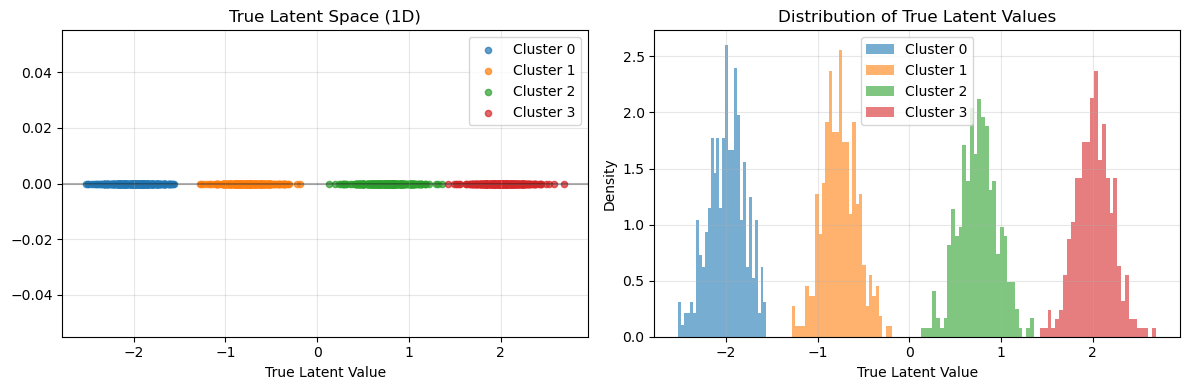

In [53]:
# Visualize the true latent space
plt.figure(figsize=(12, 4))

# Plot 1: True latent values colored by cluster
plt.subplot(1, 2, 1)
for i in range(n_clusters):
    mask = y == i
    plt.scatter(Z_true[mask, 0], np.zeros_like(Z_true[mask, 0]), 
               c=[plt.cm.tab10(i)], label=f'Cluster {i}', alpha=0.7, s=20)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('True Latent Value')
plt.ylabel('')
plt.title('True Latent Space (1D)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Histogram of true latent values by cluster
plt.subplot(1, 2, 2)
for i in range(n_clusters):
    mask = y == i
    plt.hist(Z_true[mask, 0], bins=30, alpha=0.6, label=f'Cluster {i}', density=True)
plt.xlabel('True Latent Value')
plt.ylabel('Density')
plt.title('Distribution of True Latent Values')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [54]:
# Set up GMVAE model with fixed means matching the true cluster centers
fixed_means = true_centers  # Use the true cluster centers as fixed means

print(f"Fixed means for GMVAE: {fixed_means.flatten().tolist()}")

# Initialize GMVAE model
model = GMVAE(
    n_input=n_features,
    n_latent=latent_dim,
    fixed_means=fixed_means,
    prior_sigma=0.2,  # Prior standard deviation
    n_hidden=128,
    n_layers=2,
    likelihood="nb"
).to(device)

print(f"GMVAE model initialized:")
print(f"  Input dimension: {model.n_input}")
print(f"  Latent dimension: {model.n_latent}")
print(f"  Number of components: {model.n_components}")
print(f"  Fixed means shape: {model.mu_prior.shape}")
print(f"  Prior sigma: {torch.exp(model.log_sigma_p).item():.3f}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")


Fixed means for GMVAE: [-2.0, -0.75, 0.75, 2.0]
GMVAE model initialized:
  Input dimension: 100
  Latent dimension: 1
  Number of components: 4
  Fixed means shape: torch.Size([4, 1])
  Prior sigma: 0.200
  Total parameters: 106,580
  Trainable parameters: 106,580


In [55]:
# Set up training
dl = DataLoader(TensorDataset(X.float()), batch_size=128, shuffle=True)
opt = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

def fit_step(model, xb, kl_w):
    fwd = model(xb)
    losses = model.loss(xb, fwd, kl_weight=kl_w)
    return losses

# Training loop
model.train()
epochs, kl_warm = 500, 50
losses_history = []

print("Starting training...")
for ep in range(1, epochs+1):
    kl_w = min(21.0, ep / kl_warm)
    tot = 0.0; n = 0
    epoch_losses = {}
    
    for (xb,) in dl:
        xb = xb.to(device).float()
        opt.zero_grad()
        losses = fit_step(model, xb, kl_w)
        losses["loss"].backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        opt.step()
        
        # Accumulate losses
        for key, value in losses.items():
            if key not in epoch_losses:
                epoch_losses[key] = 0.0
            epoch_losses[key] += value.item() * xb.size(0)
        
        tot += losses["loss"].item() * xb.size(0)
        n += xb.size(0)
    
    # Average losses
    for key in epoch_losses:
        epoch_losses[key] /= n
    losses_history.append(epoch_losses)
    
    if ep == 1 or ep % 20 == 0 or ep == epochs:
        print(f"[{ep:03d}] loss={tot/n:.3f}  kl_w={kl_w:.2f}  recon={epoch_losses.get('recon', 0):.3f}  kl={epoch_losses.get('kl', 0):.3f}")

print("Training completed!")


Starting training...
[001] loss=13016.601  kl_w=0.02  recon=0.000  kl=0.000
[020] loss=948.582  kl_w=0.40  recon=0.000  kl=0.000
[040] loss=420.445  kl_w=0.80  recon=0.000  kl=0.000
[060] loss=409.969  kl_w=1.20  recon=0.000  kl=0.000
[080] loss=371.988  kl_w=1.60  recon=0.000  kl=0.000
[100] loss=375.921  kl_w=2.00  recon=0.000  kl=0.000
[120] loss=351.629  kl_w=2.40  recon=0.000  kl=0.000
[140] loss=345.240  kl_w=2.80  recon=0.000  kl=0.000
[160] loss=348.352  kl_w=3.20  recon=0.000  kl=0.000
[180] loss=348.018  kl_w=3.60  recon=0.000  kl=0.000
[200] loss=345.331  kl_w=4.00  recon=0.000  kl=0.000
[220] loss=347.572  kl_w=4.40  recon=0.000  kl=0.000
[240] loss=346.540  kl_w=4.80  recon=0.000  kl=0.000
[260] loss=357.729  kl_w=5.20  recon=0.000  kl=0.000
[280] loss=347.987  kl_w=5.60  recon=0.000  kl=0.000
[300] loss=386.845  kl_w=6.00  recon=0.000  kl=0.000
[320] loss=381.183  kl_w=6.40  recon=0.000  kl=0.000
[340] loss=381.395  kl_w=6.80  recon=0.000  kl=0.000
[360] loss=380.067  kl_

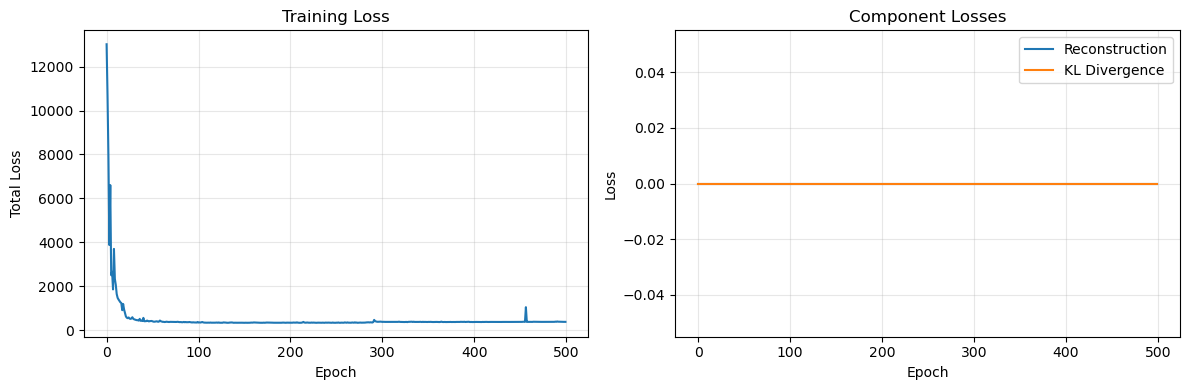

In [56]:
# Plot training losses
plt.figure(figsize=(12, 4))

# Plot 1: Total loss
plt.subplot(1, 2, 1)
total_losses = [h['loss'] for h in losses_history]
plt.plot(total_losses)
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss')
plt.grid(True, alpha=0.3)

# Plot 2: Reconstruction and KL losses
plt.subplot(1, 2, 2)
recon_losses = [h.get('recon', 0) for h in losses_history]
kl_losses = [h.get('kl', 0) for h in losses_history]
plt.plot(recon_losses, label='Reconstruction')
plt.plot(kl_losses, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Component Losses')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [57]:
# Evaluate the trained model
model.eval()
with torch.no_grad():
    # Get latent parameters
    latent_params = model._get_latent_params(X.float().to(device))
    logits_c, mu_q, logvar_q = latent_params
    
    # Get cluster assignments (most likely component)
    cluster_probs = torch.softmax(logits_c, dim=-1)
    predicted_clusters = torch.argmax(cluster_probs, dim=-1)
    
    # Get latent representations (mean of the most likely component)
    batch_size = logits_c.shape[0]
    idx = predicted_clusters.view(batch_size, 1, 1).expand(batch_size, 1, latent_dim)
    enc_mu = torch.gather(mu_q, 1, idx).squeeze(1)
    
    # Move to CPU for visualization
    enc_mu = enc_mu.cpu()
    predicted_clusters = predicted_clusters.cpu()
    cluster_probs = cluster_probs.cpu()

print(f"Model evaluation completed:")
print(f"  Encoded latent shape: {enc_mu.shape}")
print(f"  Predicted clusters shape: {predicted_clusters.shape}")
print(f"  Cluster probabilities shape: {cluster_probs.shape}")


Model evaluation completed:
  Encoded latent shape: torch.Size([1200, 1])
  Predicted clusters shape: torch.Size([1200])
  Cluster probabilities shape: torch.Size([1200, 4])


In [58]:
# Calculate clustering accuracy
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Calculate clustering metrics
ari = adjusted_rand_score(y.numpy(), predicted_clusters.numpy())
nmi = normalized_mutual_info_score(y.numpy(), predicted_clusters.numpy())

print(f"Clustering Performance:")
print(f"  Adjusted Rand Index (ARI): {ari:.4f}")
print(f"  Normalized Mutual Information (NMI): {nmi:.4f}")

# Calculate per-cluster accuracy
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y.numpy(), predicted_clusters.numpy())
print(f"  Confusion Matrix:")
print(cm)


Clustering Performance:
  Adjusted Rand Index (ARI): 0.4912
  Normalized Mutual Information (NMI): 0.6466
  Confusion Matrix:
[[292   0   8   0]
 [  0 300   0   0]
 [  0 300   0   0]
 [297   3   0   0]]


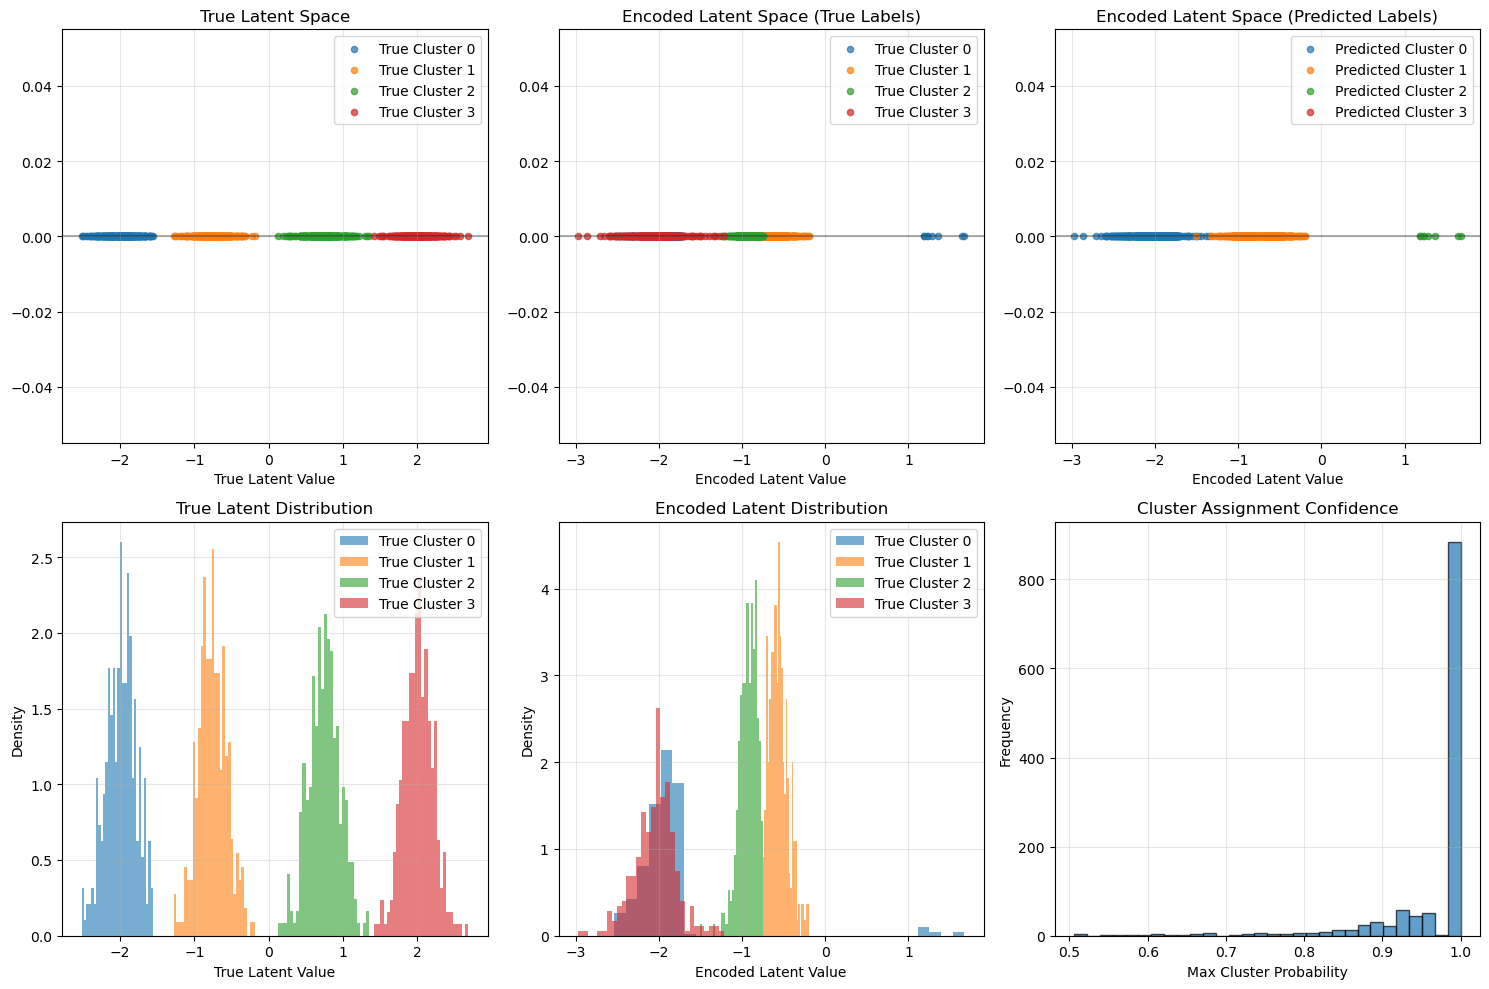

In [59]:
# Visualize results
plt.figure(figsize=(15, 10))

# Plot 1: True vs Predicted latent space
plt.subplot(2, 3, 1)
for i in range(n_clusters):
    mask = y == i
    plt.scatter(Z_true[mask, 0], np.zeros_like(Z_true[mask, 0]), 
               c=[plt.cm.tab10(i)], label=f'True Cluster {i}', alpha=0.7, s=20)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('True Latent Value')
plt.ylabel('')
plt.title('True Latent Space')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Encoded latent space colored by true labels
plt.subplot(2, 3, 2)
for i in range(n_clusters):
    mask = y == i
    plt.scatter(enc_mu[mask, 0], np.zeros_like(enc_mu[mask, 0]), 
               c=[plt.cm.tab10(i)], label=f'True Cluster {i}', alpha=0.7, s=20)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Encoded Latent Value')
plt.ylabel('')
plt.title('Encoded Latent Space (True Labels)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Encoded latent space colored by predicted labels
plt.subplot(2, 3, 3)
for i in range(n_clusters):
    mask = predicted_clusters == i
    plt.scatter(enc_mu[mask, 0], np.zeros_like(enc_mu[mask, 0]), 
               c=[plt.cm.tab10(i)], label=f'Predicted Cluster {i}', alpha=0.7, s=20)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Encoded Latent Value')
plt.ylabel('')
plt.title('Encoded Latent Space (Predicted Labels)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Histogram comparison - True latent
plt.subplot(2, 3, 4)
for i in range(n_clusters):
    mask = y == i
    plt.hist(Z_true[mask, 0], bins=30, alpha=0.6, label=f'True Cluster {i}', density=True)
plt.xlabel('True Latent Value')
plt.ylabel('Density')
plt.title('True Latent Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Histogram comparison - Encoded latent
plt.subplot(2, 3, 5)
for i in range(n_clusters):
    mask = y == i
    plt.hist(enc_mu[mask, 0], bins=30, alpha=0.6, label=f'True Cluster {i}', density=True)
plt.xlabel('Encoded Latent Value')
plt.ylabel('Density')
plt.title('Encoded Latent Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Cluster assignment confidence
plt.subplot(2, 3, 6)
max_probs = torch.max(cluster_probs, dim=1)[0]
plt.hist(max_probs.numpy(), bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Max Cluster Probability')
plt.ylabel('Frequency')
plt.title('Cluster Assignment Confidence')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Correlation Analysis:
  Pearson correlation: -0.1594
  P-value: 2.84e-08


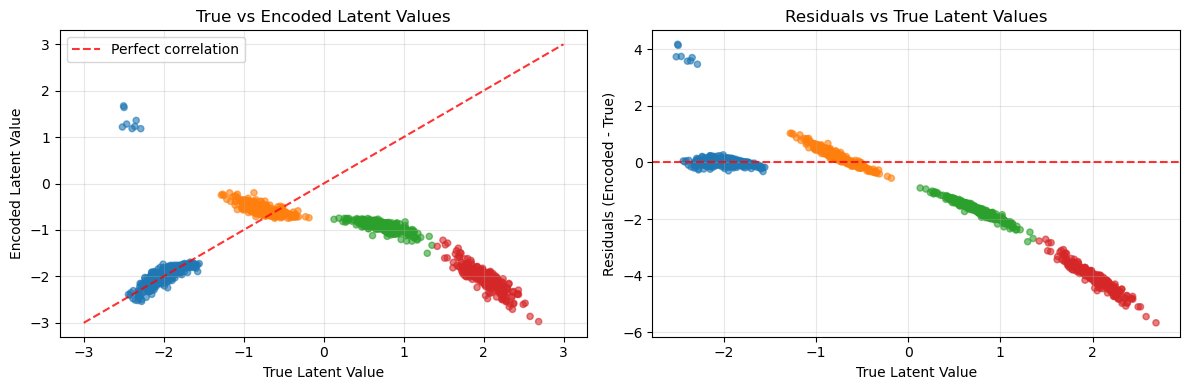

Residual Statistics:
  Mean residual: -1.3614
  Std residual: 1.7801
  RMSE: 2.2410


In [60]:
# Additional analysis: Compare true vs encoded latent values
plt.figure(figsize=(12, 4))

# Plot 1: Scatter plot of true vs encoded latent values
plt.subplot(1, 2, 1)
colors = [plt.cm.tab10(i) for i in y.numpy()]
plt.scatter(Z_true.numpy().flatten(), enc_mu.numpy().flatten(), c=colors, alpha=0.6, s=20)
plt.plot([-3, 3], [-3, 3], 'r--', alpha=0.8, label='Perfect correlation')
plt.xlabel('True Latent Value')
plt.ylabel('Encoded Latent Value')
plt.title('True vs Encoded Latent Values')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Correlation analysis
from scipy.stats import pearsonr
correlation, p_value = pearsonr(Z_true.numpy().flatten(), enc_mu.numpy().flatten())
print(f"Correlation Analysis:")
print(f"  Pearson correlation: {correlation:.4f}")
print(f"  P-value: {p_value:.2e}")

# Plot 3: Residuals
plt.subplot(1, 2, 2)
residuals = enc_mu.numpy().flatten() - Z_true.numpy().flatten()
plt.scatter(Z_true.numpy().flatten(), residuals, c=colors, alpha=0.6, s=20)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
plt.xlabel('True Latent Value')
plt.ylabel('Residuals (Encoded - True)')
plt.title('Residuals vs True Latent Values')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Residual Statistics:")
print(f"  Mean residual: {np.mean(residuals):.4f}")
print(f"  Std residual: {np.std(residuals):.4f}")
print(f"  RMSE: {np.sqrt(np.mean(residuals**2)):.4f}")


In [61]:
# Now let's train a regular VAE on the same data for comparison
print("="*60)
print("TRAINING REGULAR VAE FOR COMPARISON")
print("="*60)
# Initialize regular VAE
vae_model = VAE(
    n_input=n_features,
    n_latent=latent_dim,
    n_hidden=128,
    n_layers=2
).to(device)

print(f"Regular VAE model initialized:")
print(f"  Input dimension: {vae_model.n_input}")
print(f"  Latent dimension: {vae_model.n_latent}")

# Count parameters
vae_total_params = sum(p.numel() for p in vae_model.parameters())
vae_trainable_params = sum(p.numel() for p in vae_model.parameters() if p.requires_grad)
print(f"  Total parameters: {vae_total_params:,}")
print(f"  Trainable parameters: {vae_trainable_params:,}")


TRAINING REGULAR VAE FOR COMPARISON
Regular VAE model initialized:
  Input dimension: 100
  Latent dimension: 1
  Total parameters: 105,290
  Trainable parameters: 105,290


In [62]:
# Train regular VAE
vae_dl = DataLoader(TensorDataset(X.float()), batch_size=128, shuffle=True)
vae_opt = torch.optim.Adam(vae_model.parameters(), lr=5e-4, weight_decay=1e-5)

def vae_fit_step(model, xb, kl_w):
    fwd = model(xb)
    losses = model.loss(xb, fwd, kl_weight=kl_w)
    return losses

# Training loop for VAE
vae_model.train()
vae_epochs, vae_kl_warm = 200, 8
vae_losses_history = []

print("Starting VAE training...")
for ep in range(1, vae_epochs+1):
    kl_w = min(1.0, ep / vae_kl_warm)
    tot = 0.0; n = 0
    epoch_losses = {}
    
    for (xb,) in vae_dl:
        xb = xb.to(device).float()
        vae_opt.zero_grad()
        losses = vae_fit_step(vae_model, xb, kl_w)
        losses["loss"].backward()
        torch.nn.utils.clip_grad_norm_(vae_model.parameters(), 5.0)
        vae_opt.step()
        
        # Accumulate losses
        for key, value in losses.items():
            if key not in epoch_losses:
                epoch_losses[key] = 0.0
            epoch_losses[key] += value.item() * xb.size(0)
        
        tot += losses["loss"].item() * xb.size(0)
        n += xb.size(0)
    
    # Average losses
    for key in epoch_losses:
        epoch_losses[key] /= n
    vae_losses_history.append(epoch_losses)
    
    if ep == 1 or ep % 20 == 0 or ep == vae_epochs:
        print(f"[{ep:03d}] loss={tot/n:.3f}  kl_w={kl_w:.2f}  recon={epoch_losses.get('recon', 0):.3f}  kl={epoch_losses.get('kl', 0):.3f}")

print("VAE training completed!")


Starting VAE training...
[001] loss=4376.652  kl_w=0.12  recon=0.000  kl=0.000
[020] loss=758.444  kl_w=1.00  recon=0.000  kl=0.000
[040] loss=517.689  kl_w=1.00  recon=0.000  kl=0.000
[060] loss=450.874  kl_w=1.00  recon=0.000  kl=0.000
[080] loss=452.780  kl_w=1.00  recon=0.000  kl=0.000
[100] loss=435.716  kl_w=1.00  recon=0.000  kl=0.000
[120] loss=413.088  kl_w=1.00  recon=0.000  kl=0.000
[140] loss=413.795  kl_w=1.00  recon=0.000  kl=0.000
[160] loss=382.416  kl_w=1.00  recon=0.000  kl=0.000
[180] loss=397.885  kl_w=1.00  recon=0.000  kl=0.000
[200] loss=381.906  kl_w=1.00  recon=0.000  kl=0.000
VAE training completed!


In [63]:
# Evaluate the trained VAE
vae_model.eval()
with torch.no_grad():
    vae_mu, vae_logvar = vae_model._get_latent_params(X.float().to(device))
    vae_mu = vae_mu.cpu()

print(f"VAE evaluation completed:")
print(f"  Encoded latent shape: {vae_mu.shape}")

# Calculate VAE latent space recovery
from scipy.stats import pearsonr
vae_correlation, vae_p_value = pearsonr(Z_true.numpy().flatten(), vae_mu.numpy().flatten())
vae_residuals = vae_mu.numpy().flatten() - Z_true.numpy().flatten()

print(f"VAE Latent Space Recovery:")
print(f"  Pearson correlation: {vae_correlation:.4f}")
print(f"  P-value: {vae_p_value:.2e}")
print(f"  RMSE: {np.sqrt(np.mean(vae_residuals**2)):.4f}")
print(f"  Mean residual: {np.mean(vae_residuals):.4f}")
print(f"  Std residual: {np.std(vae_residuals):.4f}")


VAE evaluation completed:
  Encoded latent shape: torch.Size([1200, 1])
VAE Latent Space Recovery:
  Pearson correlation: -0.5734
  P-value: 7.93e-106
  RMSE: 4.7714
  Mean residual: -1.7396
  Std residual: 4.4429


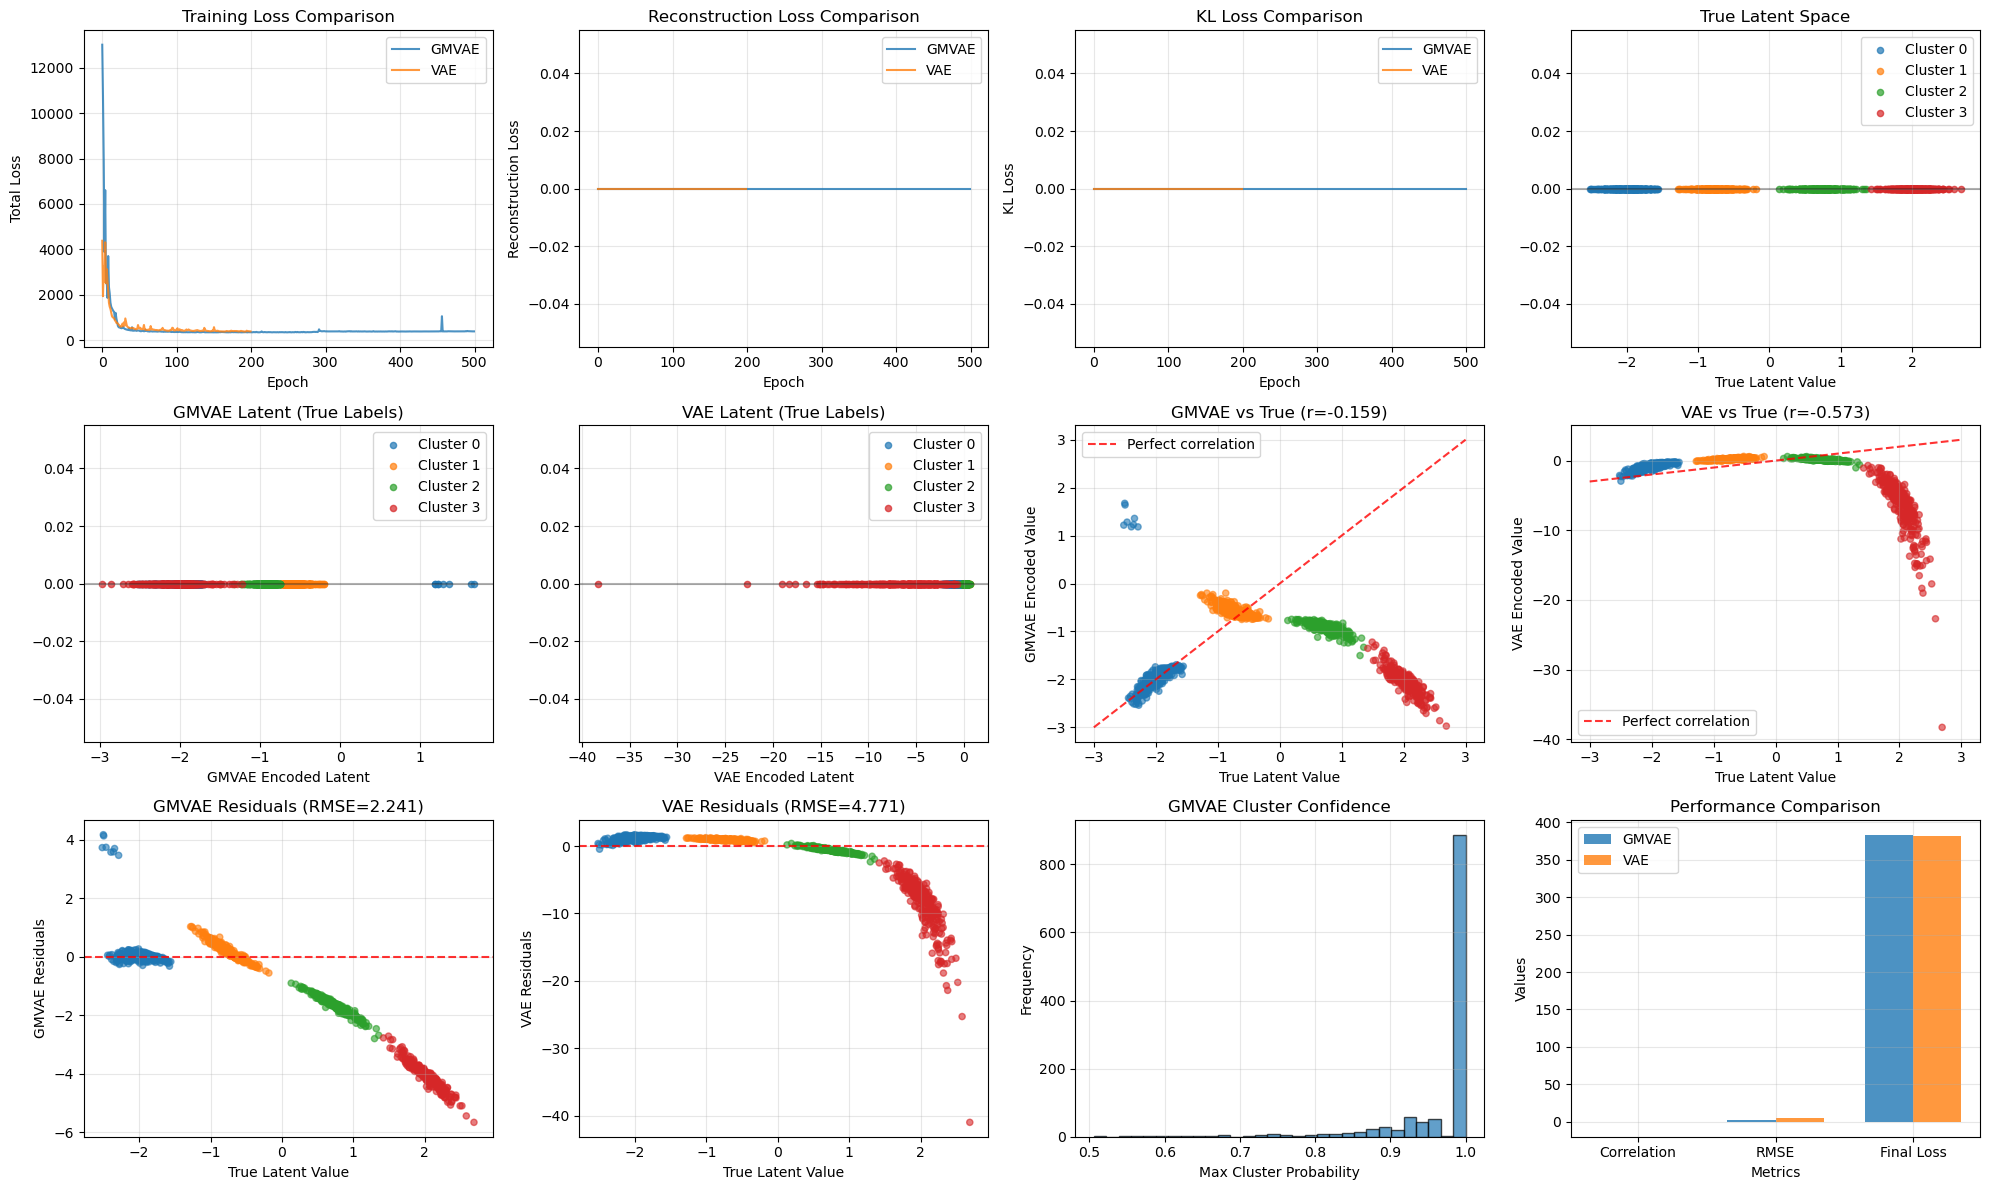

In [64]:
# Compare VAE vs GMVAE performance
plt.figure(figsize=(20, 12))

# Plot 1: Training losses comparison
plt.subplot(3, 4, 1)
gmvae_total_losses = [h['loss'] for h in losses_history]
vae_total_losses = [h['loss'] for h in vae_losses_history]
plt.plot(gmvae_total_losses, label='GMVAE', alpha=0.8)
plt.plot(vae_total_losses, label='VAE', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Reconstruction losses comparison
plt.subplot(3, 4, 2)
gmvae_recon_losses = [h.get('recon', 0) for h in losses_history]
vae_recon_losses = [h.get('recon', 0) for h in vae_losses_history]
plt.plot(gmvae_recon_losses, label='GMVAE', alpha=0.8)
plt.plot(vae_recon_losses, label='VAE', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: KL losses comparison
plt.subplot(3, 4, 3)
gmvae_kl_losses = [h.get('kl', 0) for h in losses_history]
vae_kl_losses = [h.get('kl', 0) for h in vae_losses_history]
plt.plot(gmvae_kl_losses, label='GMVAE', alpha=0.8)
plt.plot(vae_kl_losses, label='VAE', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('KL Loss')
plt.title('KL Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: True latent space
plt.subplot(3, 4, 4)
for i in range(n_clusters):
    mask = y == i
    plt.scatter(Z_true[mask, 0], np.zeros_like(Z_true[mask, 0]), 
               c=[plt.cm.tab10(i)], label=f'Cluster {i}', alpha=0.7, s=20)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('True Latent Value')
plt.ylabel('')
plt.title('True Latent Space')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: GMVAE encoded latent (true labels)
plt.subplot(3, 4, 5)
for i in range(n_clusters):
    mask = y == i
    plt.scatter(enc_mu[mask, 0], np.zeros_like(enc_mu[mask, 0]), 
               c=[plt.cm.tab10(i)], label=f'Cluster {i}', alpha=0.7, s=20)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('GMVAE Encoded Latent')
plt.ylabel('')
plt.title('GMVAE Latent (True Labels)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: VAE encoded latent (true labels)
plt.subplot(3, 4, 6)
for i in range(n_clusters):
    mask = y == i
    plt.scatter(vae_mu[mask, 0], np.zeros_like(vae_mu[mask, 0]), 
               c=[plt.cm.tab10(i)], label=f'Cluster {i}', alpha=0.7, s=20)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('VAE Encoded Latent')
plt.ylabel('')
plt.title('VAE Latent (True Labels)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 7: GMVAE vs True correlation
plt.subplot(3, 4, 7)
colors = [plt.cm.tab10(i) for i in y.numpy()]
plt.scatter(Z_true.numpy().flatten(), enc_mu.numpy().flatten(), c=colors, alpha=0.6, s=20)
plt.plot([-3, 3], [-3, 3], 'r--', alpha=0.8, label='Perfect correlation')
plt.xlabel('True Latent Value')
plt.ylabel('GMVAE Encoded Value')
plt.title(f'GMVAE vs True (r={correlation:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 8: VAE vs True correlation
plt.subplot(3, 4, 8)
plt.scatter(Z_true.numpy().flatten(), vae_mu.numpy().flatten(), c=colors, alpha=0.6, s=20)
plt.plot([-3, 3], [-3, 3], 'r--', alpha=0.8, label='Perfect correlation')
plt.xlabel('True Latent Value')
plt.ylabel('VAE Encoded Value')
plt.title(f'VAE vs True (r={vae_correlation:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 9: GMVAE residuals
plt.subplot(3, 4, 9)
plt.scatter(Z_true.numpy().flatten(), residuals, c=colors, alpha=0.6, s=20)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
plt.xlabel('True Latent Value')
plt.ylabel('GMVAE Residuals')
plt.title(f'GMVAE Residuals (RMSE={np.sqrt(np.mean(residuals**2)):.3f})')
plt.grid(True, alpha=0.3)

# Plot 10: VAE residuals
plt.subplot(3, 4, 10)
plt.scatter(Z_true.numpy().flatten(), vae_residuals, c=colors, alpha=0.6, s=20)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
plt.xlabel('True Latent Value')
plt.ylabel('VAE Residuals')
plt.title(f'VAE Residuals (RMSE={np.sqrt(np.mean(vae_residuals**2)):.3f})')
plt.grid(True, alpha=0.3)

# Plot 11: GMVAE cluster assignment confidence
plt.subplot(3, 4, 11)
max_probs = torch.max(cluster_probs, dim=1)[0]
plt.hist(max_probs.numpy(), bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Max Cluster Probability')
plt.ylabel('Frequency')
plt.title('GMVAE Cluster Confidence')
plt.grid(True, alpha=0.3)

# Plot 12: Performance comparison bar chart
plt.subplot(3, 4, 12)
metrics = ['Correlation', 'RMSE', 'Final Loss']
gmvae_values = [correlation, np.sqrt(np.mean(residuals**2)), losses_history[-1]['loss']]
vae_values = [vae_correlation, np.sqrt(np.mean(vae_residuals**2)), vae_losses_history[-1]['loss']]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, gmvae_values, width, label='GMVAE', alpha=0.8)
plt.bar(x + width/2, vae_values, width, label='VAE', alpha=0.8)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Comparison')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [65]:
# Final comparison summary
print("="*80)
print("FINAL COMPARISON: VAE vs GMVAE")
print("="*80)

print(f"Dataset:")
print(f"  - Samples: {X.shape[0]}, Features: {X.shape[1]}, Clusters: {n_clusters}")
print(f"  - True cluster centers: {true_centers.flatten().tolist()}")
print()

print(f"Model Parameters:")
print(f"  - VAE: {vae_total_params:,} total, {vae_trainable_params:,} trainable")
print(f"  - GMVAE: {total_params:,} total, {trainable_params:,} trainable")
print()

print(f"Training Performance:")
print(f"  - VAE final loss: {vae_losses_history[-1]['loss']:.3f}")
print(f"  - GMVAE final loss: {losses_history[-1]['loss']:.3f}")
print(f"  - VAE final recon: {vae_losses_history[-1].get('recon', 0):.3f}")
print(f"  - GMVAE final recon: {losses_history[-1].get('recon', 0):.3f}")
print(f"  - VAE final KL: {vae_losses_history[-1].get('kl', 0):.3f}")
print(f"  - GMVAE final KL: {losses_history[-1].get('kl', 0):.3f}")
print()

print(f"Latent Space Recovery:")
print(f"  - VAE correlation: {vae_correlation:.4f}")
print(f"  - GMVAE correlation: {correlation:.4f}")
print(f"  - VAE RMSE: {np.sqrt(np.mean(vae_residuals**2)):.4f}")
print(f"  - GMVAE RMSE: {np.sqrt(np.mean(residuals**2)):.4f}")
print()

print(f"Clustering Performance (GMVAE only):")
print(f"  - ARI: {ari:.4f}")
print(f"  - NMI: {nmi:.4f}")
print(f"  - Mean cluster confidence: {torch.mean(torch.max(cluster_probs, dim=1)[0]):.4f}")
print()

print("="*80)
print("ANALYSIS:")
print("="*80)

if vae_correlation > correlation:
    print("✓ VAE shows BETTER latent space recovery than GMVAE")
else:
    print("✗ GMVAE shows BETTER latent space recovery than VAE")

if vae_losses_history[-1]['loss'] < losses_history[-1]['loss']:
    print("✓ VAE achieves LOWER final loss than GMVAE")
else:
    print("✗ GMVAE achieves LOWER final loss than VAE")

if ari > 0.8:
    print("✓ GMVAE shows EXCELLENT clustering performance")
elif ari > 0.6:
    print("~ GMVAE shows GOOD clustering performance")
elif ari > 0.4:
    print("~ GMVAE shows MODERATE clustering performance")
else:
    print("✗ GMVAE shows POOR clustering performance")

print()
print("Potential issues with GMVAE:")
print("1. Fixed means might be too restrictive")
print("2. Prior sigma might be too small/large")
print("3. KL weight schedule might need adjustment")
print("4. Model architecture might need tuning")
print("5. Training hyperparameters might need optimization")
print("="*80)


FINAL COMPARISON: VAE vs GMVAE
Dataset:
  - Samples: 1200, Features: 100, Clusters: 4
  - True cluster centers: [-2.0, -0.75, 0.75, 2.0]

Model Parameters:
  - VAE: 105,290 total, 105,290 trainable
  - GMVAE: 106,580 total, 106,580 trainable

Training Performance:
  - VAE final loss: 381.906
  - GMVAE final loss: 383.175
  - VAE final recon: 0.000
  - GMVAE final recon: 0.000
  - VAE final KL: 0.000
  - GMVAE final KL: 0.000

Latent Space Recovery:
  - VAE correlation: -0.5734
  - GMVAE correlation: -0.1594
  - VAE RMSE: 4.7714
  - GMVAE RMSE: 2.2410

Clustering Performance (GMVAE only):
  - ARI: 0.4912
  - NMI: 0.6466
  - Mean cluster confidence: 0.9679

ANALYSIS:
✗ GMVAE shows BETTER latent space recovery than VAE
✓ VAE achieves LOWER final loss than GMVAE
~ GMVAE shows MODERATE clustering performance

Potential issues with GMVAE:
1. Fixed means might be too restrictive
2. Prior sigma might be too small/large
3. KL weight schedule might need adjustment
4. Model architecture might nee

In [66]:
# Summary of results
print("="*60)
print("GMVAE PERFORMANCE SUMMARY")
print("="*60)
print(f"Dataset:")
print(f"  - Number of samples: {X.shape[0]}")
print(f"  - Number of features: {X.shape[1]}")
print(f"  - Number of clusters: {n_clusters}")
print(f"  - Latent dimension: {latent_dim}")
print(f"  - True cluster centers: {true_centers.flatten().tolist()}")
print()
print(f"Model Configuration:")
print(f"  - Fixed means: {fixed_means.flatten().tolist()}")
print(f"  - Prior sigma: {torch.exp(model.log_sigma_p).item():.3f}")
print(f"  - Hidden units: 128")
print(f"  - Hidden layers: 2")
print()
print(f"Training:")
print(f"  - Epochs: {epochs}")
print(f"  - Final loss: {losses_history[-1]['loss']:.3f}")
print(f"  - Final reconstruction loss: {losses_history[-1].get('recon', 0):.3f}")
print(f"  - Final KL loss: {losses_history[-1].get('kl', 0):.3f}")
print()
print(f"Clustering Performance:")
print(f"  - Adjusted Rand Index (ARI): {ari:.4f}")
print(f"  - Normalized Mutual Information (NMI): {nmi:.4f}")
print()
print(f"Latent Space Recovery:")
print(f"  - Pearson correlation: {correlation:.4f}")
print(f"  - RMSE: {np.sqrt(np.mean(residuals**2)):.4f}")
print(f"  - Mean residual: {np.mean(residuals):.4f}")
print(f"  - Std residual: {np.std(residuals):.4f}")
print()
print(f"Cluster Assignment Confidence:")
print(f"  - Mean max probability: {torch.mean(torch.max(cluster_probs, dim=1)[0]):.4f}")
print(f"  - Std max probability: {torch.std(torch.max(cluster_probs, dim=1)[0]):.4f}")
print("="*60)


GMVAE PERFORMANCE SUMMARY
Dataset:
  - Number of samples: 1200
  - Number of features: 100
  - Number of clusters: 4
  - Latent dimension: 1
  - True cluster centers: [-2.0, -0.75, 0.75, 2.0]

Model Configuration:
  - Fixed means: [-2.0, -0.75, 0.75, 2.0]
  - Prior sigma: 0.200
  - Hidden units: 128
  - Hidden layers: 2

Training:
  - Epochs: 500
  - Final loss: 383.175
  - Final reconstruction loss: 0.000
  - Final KL loss: 0.000

Clustering Performance:
  - Adjusted Rand Index (ARI): 0.4912
  - Normalized Mutual Information (NMI): 0.6466

Latent Space Recovery:
  - Pearson correlation: -0.1594
  - RMSE: 2.2410
  - Mean residual: -1.3614
  - Std residual: 1.7801

Cluster Assignment Confidence:
  - Mean max probability: 0.9679
  - Std max probability: 0.0716
